## Using Random Forest Classificaiton to Predict Good or Poor Health Based on the Behavioral Risk Factor Surveillance System Survey

### Introduction

The Behavioral Risk Factor Surveillance System (BRFSS) is an annual health-related telephone survey conducted by the United States' Centers for Disease Control and Prevention (CDC) regarding their health-related risk behaviors, chronic health conditions, and use of preventive services [[CDC's BRFSS site](https://www.cdc.gov/brfss/index.html)].

The resultant public domain Real World Data (RWD) are readily avaliable via the [CDC's site](https://www.cdc.gov/brfss/data_documentation/index.htm). The datasets typically consist of appromixtely 300,000 to 400,000 surveyed individuals, with about 250 to 350 variables (mapping to asked behavioral questions or calculated variables).

**Goal**: The goal for this data project is to to use one of the annual BRFSS datasets to make a *predictive classification model* to determine whether a subject would be categorized in 'Good or Better' health or 'Fair or Poor' health based on the survey findings.

### Methods

**Data Used**: I downloaded the the BRFSS data for 2015. Instead of directly downloading the data in ASCII or SAS format from the CDC site, I used the [CSV file generated from Kaggle](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system). They generated the CSV file after importing the SAS data using Pandas. This seemed to be the better approach than starting from scratch as my goal for this project is to focus on the modeling rather than extraction and transformation. As the dataset consists of several hundred features with some arcane variable names, the 2015 BRFSS Codebook is essential to understand their meaning and importance ([link to Codebook PDF here](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf)).

**Modeling**: I'll start by using a Decision Tree Classifier that fits the data into the 'Good or Better' or 'Fair or Poor' Health classes. The benefit of this is the ease of understanding and interpreting the original data. However, the disadvantage of the approach is that the a decision tree overfits to the training data, and as such is not a robust predictive model.

After developing some intuition of the data, I'll implement a Random Forest Classifier, which uses bagging and forests (ensemble of mulitple decision trees), to generate a robust model with lower variance.

Lastly, I'll use cross validation to to optimize the hyperparameters for improved prediction while further minimizing overfitting and selection bias.

**Scoring:** A number of scoring methods can be used to assess model robustness. Some of these include accuracy, precision and recall, and the reciever operator characterestic. As I'll explore the data, I'll make and explain the choices for the scoring method I used.

-----

### Data and Libraries Used

**Data Sources:**

[Direct link to the BRFSS zipped data (3 GB)](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system/download). I used the 2015.csv for this analysis.

[Link to BRFSS Codebook PDF here](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf). Needed to interpret variables.


**Libraries and Programs Used:**

[Graphviz](https://graphviz.org/). Needed to render images of decision trees (the python library generates a .dot file). On Debian and Ubuntu, `sudo apt install graphviz` can be used to install Graphviz from the repository.

The [Scikit-Learn library](https://scikit-learn.org/stable/) will be used to implement all the models, validation and scoring for this project. A number of other common libraries (Pandas, NumPy, Matplotlib, etc) will be used as well. I'll import them all on top [based on the python style guide](https://www.python.org/dev/peps/pep-0008/#imports), but I'll highlight their first use as I've found it helpful to clearly know what library a function is derived from when its called for the first time.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz # to export tree as a .dot file
from subprocess import call # for system call (to generate tree image)
from IPython.display import Image # for loading tree image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score, confusion_matrix
import time # for measuring runtime during cross validation
from joblib import dump, load #to save fitted models to disk (saves a lot of time)

### Loading and Cleaning the Dataset

Importing the CSV into our workspace, and then selecting a subset of the total data for faster fitting.

In [2]:
seed = 100 # if you want to reproduce my work

df = pd.read_csv('2015.csv')
print(f'The dataset has {df.shape[0]} subjects and {df.shape[1]} variables')

df = df.sample(120000, random_state=seed)
print(f'The sampled dataset has {df.shape[0]} subjects and {df.shape[1]} variables')

The dataset has 441456 subjects and 330 variables
The sampled dataset has 120000 subjects and 330 variables


In [3]:
df.head(10)

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_PAREC1,_PASTAE1,_LMTACT1,_LMTWRK1,_LMTSCL1,_RFSEAT2,_RFSEAT3,_FLSHOT6,_PNEUMO2,_AIDTST3
59442,9.0,4.0,b'04062015',b'04',b'06',b'2015',1100.0,2.015008e+09,2.015008e+09,NaN,...,3.0,2.0,3.0,3.0,4.0,1.0,2.0,NaN,NaN,2.0
295595,38.0,9.0,b'09112015',b'09',b'11',b'2015',1100.0,2.015002e+09,2.015002e+09,1.0,...,4.0,2.0,3.0,3.0,4.0,2.0,2.0,NaN,NaN,2.0
382864,49.0,4.0,b'05202015',b'05',b'20',b'2015',1100.0,2.015009e+09,2.015009e+09,NaN,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
440752,72.0,9.0,b'10262015',b'10',b'26',b'2015',1100.0,2.015005e+09,2.015005e+09,NaN,...,4.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0
23981,5.0,5.0,b'05242015',b'05',b'24',b'2015',1200.0,2.015004e+09,2.015004e+09,NaN,...,9.0,9.0,3.0,3.0,4.0,9.0,9.0,9.0,9.0,NaN
268137,35.0,2.0,b'04032015',b'04',b'03',b'2015',1100.0,2.015000e+09,2.015000e+09,1.0,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,2.0,1.0,2.0
329460,44.0,2.0,b'02032015',b'02',b'03',b'2015',1100.0,2.015001e+09,2.015001e+09,1.0,...,4.0,2.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,2.0
437689,72.0,7.0,b'07302015',b'07',b'30',b'2015',1100.0,2.015002e+09,2.015002e+09,1.0,...,4.0,2.0,3.0,3.0,4.0,2.0,2.0,NaN,NaN,1.0
246807,32.0,2.0,b'02092015',b'02',b'09',b'2015',1100.0,2.015001e+09,2.015001e+09,1.0,...,1.0,1.0,3.0,3.0,4.0,1.0,1.0,NaN,NaN,1.0
186609,26.0,1.0,b'03192015',b'03',b'19',b'2015',1100.0,2.015003e+09,2.015003e+09,1.0,...,9.0,9.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0


If we look at the columns, we see quite a few `NaN` in different columns. Looking at the codebook, we see that the NaN usually replaces a `blank` value (e.g. in *\_FLSHOT6*, 1,2, and 9 represent responses, whereas `blank` represents an exclusion critera of age less than 65.)

Unfortunately `NaN` cannot be fed into our machine learning models, so rows with `NaN` will have to excluded, or the `NaN` will have to be replaced by some alternative ([Imputation, wikipedia link](https://en.wikipedia.org/wiki/Imputation_%28statistics%29)).

In [4]:
print(df.dropna().shape)

(0, 330)


Excluding observations with any `NaN` is clearly a bad idea because all the rows get dropped! Ideally, each feature will be studied, and a valid reasonable replacement will be chosen. But given the large number of features, this might not be the best initial approach. Once a model is made, we can see the importance of each feature, and then look at a more fine-grained approach to deal with `NaN`. Until then, a naive, but reasonable first approach would be to replace the `NaN` with the mean value of that feature. I'll also drop three non-numeric columns (that are the day, month, and year for the interiew)

In [5]:
df = df.fillna(df.mean())
df = df.select_dtypes('number')

I'm interested in the feature column `_RFHLTH` as the predicted class.  From the [codebook](https://www.cdc.gov/brfss/annual_data/2015/pdf/codebook15_llcp.pdf), the `_RFHLTH` variable describes 'Adults with good or better health'

1 = Good or better health

2 = Fair or poor health

9 = Missing data

It is a calculated variable, based on the discrete variable `GENHLTH`.  This and a few other variables that have no responses have to be dropped from our data frame&mdash; I learned that I need to drop those variables after making an exploratory model and noticing a `NaN` error despite dropping all the `NaN`. They had no non-NaN value to use as a replacement.

In the ['Helpful Resources'](#help_rec), I link to an excellent guide that excludes several other features (unfortunately without a clear explanation), resulting in differently weighted feature importance in their final model.


In [6]:
df = df.drop(columns = ['PAINACT2', 'QLMENTL2', 'QLSTRES2','QLHLTH2', 'GENHLTH'])

I'll plot the distribution of `_RFHLTH` variable to get an intuitive idea of the data spread. This is important to clean up any missing data (if its a small percent), or to see if our class labels are imbalanced (which has implications for model scoring methods)

_RFHLTH
1.0    97272
2.0    22411
9.0      317
Name: _RFHLTH, dtype: int64


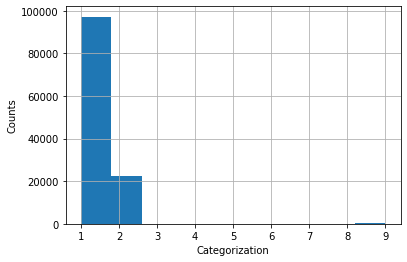

In [7]:
df['_RFHLTH'].hist()
plt.xlabel('Categorization')
plt.ylabel('Counts')

print(df.groupby(['_RFHLTH'])['_RFHLTH'].count())

A small percentage of `_RFHLTH` has missing labels. I'll simply exclude them. For convention, I'll rename `2` as `0` as the 'bad health' class and pop the label column as a separate dataframe for use in our models

In [8]:
df = df[df['_RFHLTH'].isin([1,2])]
df['_RFHLTH'] = df['_RFHLTH'].replace({2:0})
label = df.pop('_RFHLTH')

I'll be dividing the dataset into a training and test dataset for evaluating the decision tree and random forests classification models. 

### Splitting Data into a Training and Test Set

I'm splitting the data into the a training set which will be used for training our models, and a test set to evaluate our trained models. I've chosen the training/test split as 75/25. There is no hard and fast rule about the splitting ratio, but various sources suggest 20-30% seems reasonable as the test split [[1](https://developers.google.com/machine-learning/crash-course/training-and-test-sets/splitting-data), [2](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), [3](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)]. The training data will also be used for cross validation (which uses its subset for validation).

In [9]:
# from the sklearn.model_selection library
# stratify selects the training groups to reflect label distribution

X_train, X_test, y_train, y_test = train_test_split(df, label, 
                                                    train_size=0.75,
                                                    random_state=seed,
                                                    stratify = label)

### Functions to Predict, Visualize, and Evaluate Classification Models

Before training and selecting the best classification models, I've made some wrapper functions to speed up the repetitive tasks of generating, evaluating and visualizing predictions. Once we understand what they do, we can move onto training and predicting with our models.

The first function `predict_train_test()` takes a fitted model class, the training dataset and test dataset as input. The output is the class 1 label probabilites (needed to make the ROC curves) and class predictions for both the training and testing datasets.

The second function `visualize_tree()` plots the tree to visualize the tree upto a depth of 5 (you can change `max_depth` as desired) to see which features are most important (assessed via Gini impurity) during classification.

The third function `important_features()` simply lists the top ten features by their importance in the model fit.

In [10]:
def predict_train_test(model, xtrain, xtest):
    
    # make predictions for training and test data
    # .predict_proba predicts probability of each observation being class 0 or 1
    # As we want probabilities of class 1, we are selection column 1

    _train_proba = model.predict_proba(xtrain)[:, 1]
    _test_proba = model.predict_proba(xtest)[:, 1]

    _train_predict = model.predict(xtrain)
    _test_predict = model.predict(xtest)
    
    return _train_proba, _test_proba, _train_predict, _test_predict

In [11]:
def visualize_tree(_tree, image_name):
    # image_name is a string you provide
    
    # from sklearn.tree to export .dot file
    export_graphviz(_tree, image_name+'.dot', max_depth = 5, 
                    feature_names = features,
                    class_names = ['poor health', 'good health'],
                    filled = True )

    # from suprocess library
    call(['dot', '-Tpng', image_name+'.dot', '-o', image_name+'.png', '-Gdpi=200'])

    # IPython.display library
    return Image(filename=image_name+'.png')


In [12]:
features = list(X_train.columns)


def important_features(_features, fitted_model, out=10):
    feat_imp = pd.DataFrame({'feature': _features,
                             'importance': fitted_model.feature_importances_}).\
                              sort_values('importance', ascending=False)
    
    return feat_imp.head(out)
    

The function `scoring metrics()` takes the output from the `predict_train_test` function to generate scoring metrics: the accuracy, precision, and the area under the curve (AUC) of the ROC, as well as plotting the ROC.

The class label distribution is imbalanced, i.e. the healthy class is much larger than the other class (81 to 19%). When the class distribution is imbalanced, the accuracy metric is not quite as useful for model evaluation. This is easy to see from the definition of accuracy:

<center> Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$ </center>

where TP = True Positive, TN = True Negative, FP = False Positive, and FN = False Negative

Because one of the classes is much smaller than the other, if our model simply predicts 1 for *all* input, at a minimum the accuracy will be 0.81. As such, accuracy (or precision) is not an ideal evaluation method for this dataset (See ['Helpful Resources'](#help_rec) below for further reading). A metric that only evaluates each class prediction independently is more useful for our needs. The Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC), which is based on plotting the sensitivity and (1-specificity) at probability thresholds from 0 to 1 is much more useful for evaluating our model. As each axis is derived from a measure indpendent of the other class label (ground truth), the respective class sizes do not affect this parameter.

I also plot the confusion matrix using the function `display_confusion()`, which is another way to visualize the TP, TN, FP, and FN, and can be used to derive the above evaluation methods.

In [13]:
def scoring_metrics(ytr_true, ytr_pred, ytr_prob, y_true, y_pred, y_prob):
    # we don't really need to plot the training ROC curve
    # but it is nice to have the scores printed for comparison
    # input is (y_training_label, y_training_prediction, y_training_probability,
    #           y_test_label, y_test_prediction, y_test_probability)
    
    y_base = np.ones(len(y_true))
    y = {'Training Data': [ytr_true, ytr_pred, ytr_prob],
         'Baseline': [y_true, y_base, y_base],
         'Test Data':  [y_true, y_pred, y_prob]}
    for i in y:
        # functions from the sklearn.metrics library
        scores = {'accuracy':   accuracy_score(y[i][0], y[i][1]),
                  'precision': precision_score(y[i][0], y[i][1]),
                  'roc_auc':     roc_auc_score(y[i][0], y[i][2])}
        print(f"{i:13}: Accuracy: {scores['accuracy']:<4.2} Precision: {scores['precision']:<4.2} ROC_AUC: {scores['roc_auc']:<.2}")
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    # generally the baseline ROC AUC for classification is 0.5
    fpr_base, tpr_base, _ = roc_curve(y_true, y_base)
    
    plt.plot(fpr, tpr, 'cornflowerblue', label='Model')
    plt.plot(fpr_base, tpr_base, 'r:', label='Baseline')
    plt.title('ROC Curve', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend()
    plt.grid(1)
    
    return scores

In [14]:
def display_confusion(y_true, y_pred):
    
    # from the sklearn.metrics library
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (6,6))
    # if you put the ticks later, plot formatting breaks
    plt.xticks([0,1], ['Bad Health', 'Good Health'])
    plt.yticks([0,1], ['Bad Health', 'Good Health'], rotation = 90, va='center')

    plt.imshow(cm, cmap='Blues')
    # plt.text only plots one 'point' at a time, thus the loop
    for i,j,k in zip([0, 1, 0, 1], [0, 0, 1, 1], [str(i) for i in np.reshape(cm,-1)]):
        plt.text(i,j,k, horizontalalignment='center', verticalalignment='center')

    plt.colorbar()
    plt.xlabel('Predicted Value')
    plt.ylabel('True Value')
    plt.title('Confusion Matrix')
    return

### Fitting and Predicting Using a Decision Tree

Now that all my ducks are in a row, I can start modeling! First, I'll use a decision tree. Decision trees are great to generate an understanding of what features are the most important in classifying our data, but their largest disadvantage is that it overfits the training data, and as such, results in poor test data evaluation.

In [15]:
# from the sklearn.tree library
tree = DecisionTreeClassifier(random_state = seed)
tree.fit(X_train, y_train)

print('max depth:{}'.format(tree.tree_.max_depth),
     '\nnode count:{}'.format(tree.tree_.node_count), '\n')

print(important_features(features, tree))

max depth:54 
node count:14623 

      feature  importance
66   DIFFWALK    0.193926
22   PHYSHLTH    0.139281
249     _BMI5    0.014272
225   _LLCPWT    0.013487
62   QLACTLM2    0.013163
253   _EDUCAG    0.011520
45   DIABETE3    0.011200
215    _STSTR    0.010970
58   INTERNET    0.010477
273  _VEGESUM    0.010160


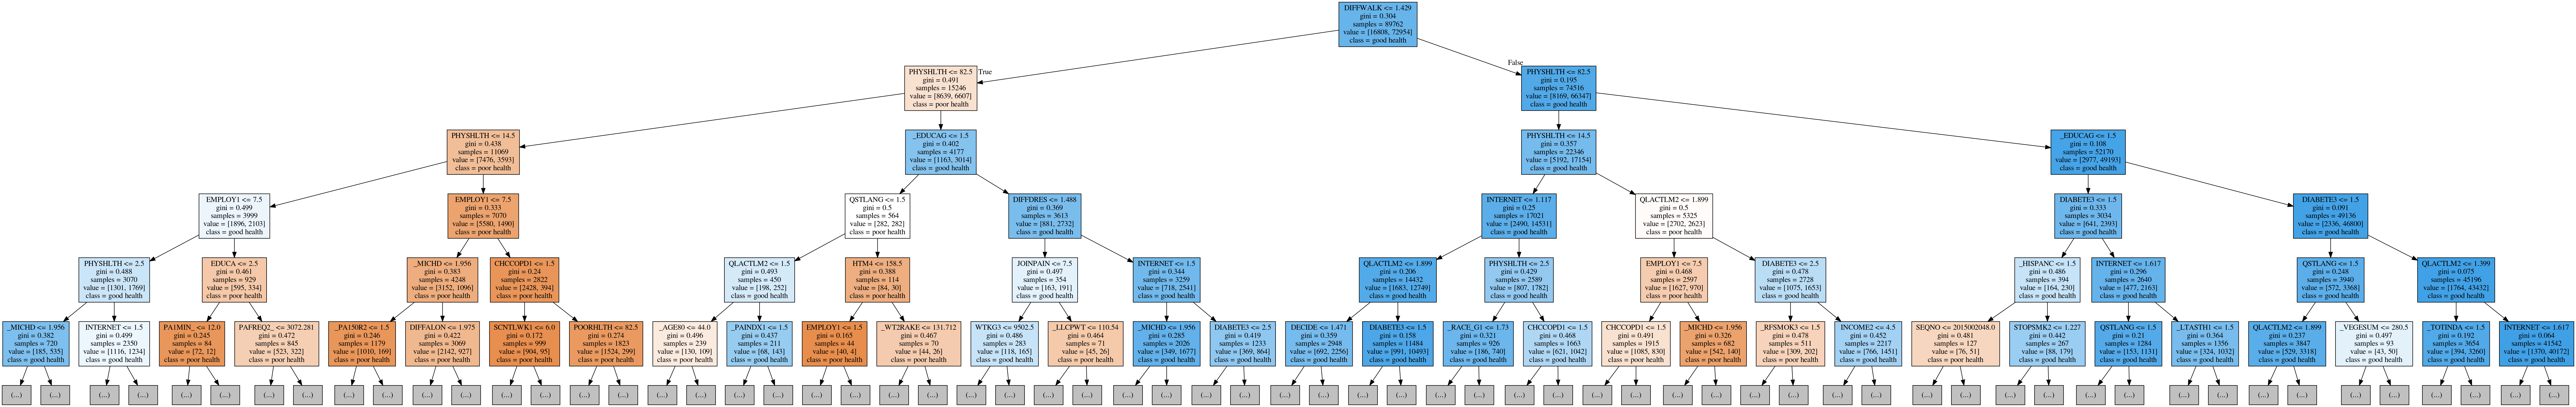

In [16]:
visualize_tree(tree, 'tree')

Training Data: Accuracy: 1.0  Precision: 1.0  ROC_AUC: 1.0
Baseline     : Accuracy: 0.81 Precision: 0.81 ROC_AUC: 0.5
Test Data    : Accuracy: 0.82 Precision: 0.89 ROC_AUC: 0.7


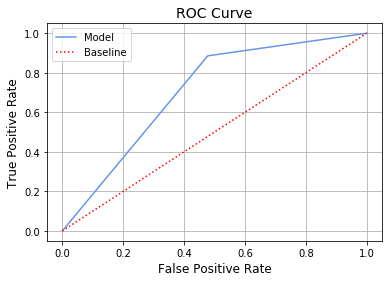

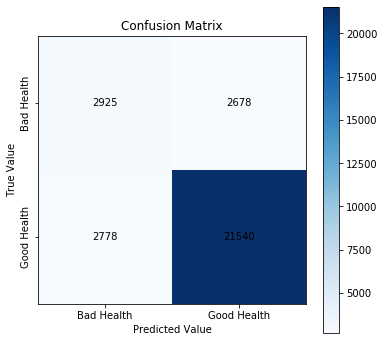

In [17]:
train_proba, test_proba, train_predict, test_predict = predict_train_test(tree, X_train, X_test)
scores = scoring_metrics(y_train, train_predict, train_proba, y_test, test_predict, test_proba)
display_confusion(y_test, test_predict)

We see that the decision tree does a great job fitting to the training data, The accuracy, precision and the AUC are all 1.0. But as we expected, the model overfit to the training data. The AUC is 0.7, leaving us with room for improvement. 

### Random Forest 🌲🌳🌲🌲🌳

Random Forests are an ensemble of decision tress, which correct for overfitting (lower the variance) by the use of bagging (different trees have randomly selected subsets of the data)  and feature bagging (random feature selection for different trees).

In [18]:
forest = RandomForestClassifier(n_estimators=50, 
                                random_state=seed, 
                                n_jobs=-1)

forest.fit(X_train, y_train)

## just an example of the of the trees in the ensemble (full list = len(n_estimators))
for i in forest.estimators_[0:1]:
    print(i)
    
n_nodes = []
max_depths = []

for tre in forest.estimators_:
    n_nodes.append(tre.tree_.node_count)
    max_depths.append(tre.tree_.max_depth)

# some parameters and results for sanity check
print('Number of trees:', len(forest.estimators_))
print('Average number of nodes:', int(np.mean(n_nodes)))
print('Average maximum depth:', int(np.mean(max_depths)))
print('Maximium maximum depth:', max(max_depths))
print('\n')
print(important_features(features, forest))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=186422792, splitter='best')
Number of trees: 50
Average number of nodes: 16388
Average maximum depth: 44
Maximium maximum depth: 53


      feature  importance
22   PHYSHLTH    0.038686
66   DIFFWALK    0.033372
62   QLACTLM2    0.030064
24   POORHLTH    0.027691
63   USEEQUIP    0.019788
68   DIFFALON    0.016334
95   JOINPAIN    0.016320
55    EMPLOY1    0.016246
311  _LMTSCL1    0.015762
67   DIFFDRES    0.012994


We immediately see how the weight of each feature importance has changed when the ensemble approach is used. Furthermore, the importance of the two top features has switched. The original decision tree was weighted `DIFFWLK` much more than `PHYSHLTH`. Not only are these two features flipped, but their importance is more closer to the other top ten features.

Let's finish predicting the training and test sets.

Training Data: Accuracy: 1.0  Precision: 1.0  ROC_AUC: 1.0
Baseline     : Accuracy: 0.81 Precision: 0.81 ROC_AUC: 0.5
Test Data    : Accuracy: 0.87 Precision: 0.89 ROC_AUC: 0.89


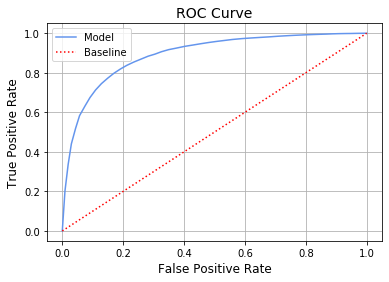

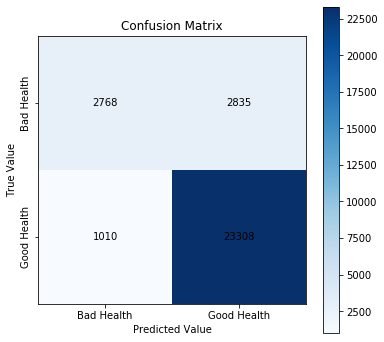

In [19]:
rftrain_proba, rftest_proba, rftrain_predict, rftest_predict = \
                                            predict_train_test(forest, X_train, X_test)

scores = scoring_metrics(y_train, rftrain_predict, rftrain_proba, y_test, rftest_predict, rftest_proba)
display_confusion(y_test, rftest_predict)

We can see that the random forest model lower our variance (decreases overfitting) compared to the decision tree. The AUC improves from 0.7 to 0.89 without any optimization of hyperparameters.

### Optimizing Hyperparameters using Cross Validation

Hyperparameters are model parameters whose value isn't learned during the fitting process, i.e. they determine the initial conditions of our model. I'll use cross validation (more specifically k-fold cross validation) to iterate through all the parameter space ('the grid') to obtain the best combination of hyperparameters. As this is quite exhaustive, this is a very slow process. Another alternative would be use to the `RandomizedSearchCV` function from the scikit-learn libary, which randomly selects from the parameter grid for parameter selection.

In [24]:
# params = {'n_estimators': [50,100, 150, 200, 250],
#           'min_samples_split': [5, 10, 20, 30, 40, 50],
#           'max_depth': [30, 40, 50, 60]}
# {'max_depth': 60, 'min_samples_split': 50, 'n_estimators': 250}


# using the scikit.model_selection library for GridSearchCV
params = {'n_estimators': [50, 100, 250, 350],
          'min_samples_split': [20, 30, 40],
          'min_samples_leaf': [1, 10, 20],
          'max_depth': [40, 50, 60]}

CVforest = RandomForestClassifier(random_state=seed, n_jobs=-1)

rs = GridSearchCV(CVforest, params, scoring = 'roc_auc', cv=5)

start = time.time()
rs.fit(X_train, y_train)
end = time.time()
print(f'{((end-start)/3600):.2f} hours')
print('The best parameters are:')
print(rs.best_params_)

0.05 hours
The best parameters are:
{'min_samples_split': 30, 'n_estimators': 350}


We can directly plug-in the best estimator parameters into our new classifier

In [25]:
cvforest = rs.best_estimator_
cvforest.fit(X_train, y_train)

print(important_features(features, cvforest))

      feature  importance
22   PHYSHLTH    0.070619
66   DIFFWALK    0.058347
62   QLACTLM2    0.048282
24   POORHLTH    0.037721
63   USEEQUIP    0.029067
55    EMPLOY1    0.027229
68   DIFFALON    0.023812
311  _LMTSCL1    0.020115
94   ARTHSOCL    0.014797
41   CHCCOPD1    0.014373


The feature importance order has not changed for the top 5 features compared to the original random forest model. Some of the weights have shifted with the increased trees. This suggets that our original model was fairly well optimized to begin with and the increase in trees will slightly lower the variance for a slight trade-off in bias (can be seen by lower scores for the training dataset below).

Training Data: Accuracy: 0.93 Precision: 0.93 ROC_AUC: 0.98
Baseline     : Accuracy: 0.81 Precision: 0.81 ROC_AUC: 0.5
Test Data    : Accuracy: 0.87 Precision: 0.89 ROC_AUC: 0.9


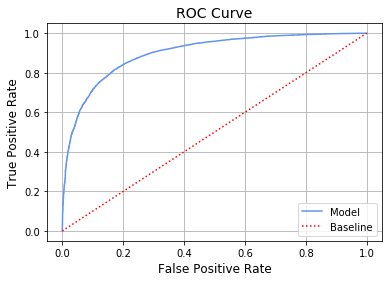

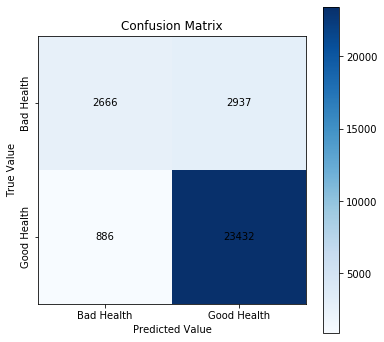

In [26]:
cvtrain_proba, cvtest_proba, cvtrain_predict, cvtest_predict = \
                                            predict_train_test(cvforest, X_train, X_test)

scores = scoring_metrics(y_train, cvtrain_predict, cvtrain_proba, y_test, cvtest_predict, cvtest_proba)
display_confusion(y_test, cvtest_predict)


We do see a very modest improvement in our recall after optimization. Although optimizing hyperparmaters can make a large difference in some models, in our case it was a minor improvement (at the cost of decreased specificity).

As you may have noticed, I did not visualize a tree from either Random Forest. Each tree in the forest will show set of features, and will not tell the true picture which comes from combining them into the ensemble model.

### Conclusions

I demonstrated the use of the a Random Forest (RF) model to predict the health of a subject based on their survey responses. The RF model shows a 28% improvement in the AUC compared to the overfitted Decision Tree classifier. I also demonstrated the use of cross-validation to optimize the hyperparmeters. However, in this particular case, the cross-validated model had a slightly slightly higher AUC (1.1% improvement) than the baseline RF model.

As to the bigger picture, what does our model tell us? It tells us that two of the most important predictors of of a subject's health is the number of '...days during the past
30 days was your physical health not good?' (`PHYSHLTH`) and if they have a '...serious difficulty walking or climbing stairs?' (`DIFFWALK`). I found this finding interesting for two reasons. The first was that although intuitively it makes sense that any problems in the immediate past are a good predictor a person's overall health classification, it is only one of several other similar (but lesser) weighed factors that contribute to their final health status. Secondly, although the survey asked for both physical and mental health (`MENTHLTH`) status in the past 30 days, and both questions had a similar (but not exact) distribution of responses, mental health was much less important as a predictor for their overall health classification.

The scope of this project can be extended for future projects in a few different ways. A comparison between the predictions of the above model to a model that only uses `PHYSHLTH` and `DIFFWALK` could be carried out, using AUC as scoring metric. A model that ignores short term (less than 30 days) behaviour may also be constructed. As mentioned earlier, the `_RFHLTH` parameter is derived from the `GENHLTH` discrete variable. Instead of making a classifier, a regressor could also be constructed. Lastly, instead of modeling, the statistical signficance of the differences in the top important features could also be calculated, providing a wholistic approach of the dataset, from analysis to modeling.

-------------

###  Helpful Resources <a id='help_rec'></a>

The [Random Forest in Python](https://enlight.nyc/projects/random-forest/) used the same dataset to build their classification model, and I used their notebook as a guide/comparison for my own analysis. However, I made different choices when it came to feature exclusion. I only excluded the `GENHLTH` column as the `_RFHLTH` is a calculated variable based on the former. They chose to exclude several other questions about the survey-taker's health within the past 30 days. This is reflected in our differing findings. In my model, the `PHYSHLTH` feature is the most important whereas `DIFFWALK` is in theirs.

Evaluating imbalanced models:
* [Shir Meir Lador(Towards Data Science) - What metrics should be used for evaluating a model on an imbalanced data set?](https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba)
* [David Batista - Evaluation Metrics, ROC-Curves and imbalanced datasets](http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/)
* [Sean Owen(Stackexchange) - Advantages of AUC vs standard accuracy](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy)